## Analyze KNN Results

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.neighbors import KNeighborsClassifier
# from PIL import Image

In [2]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from utils import read_json, load_image, read_lists, prepare_device
from utils.model_utils import quick_predict
from utils import informal_log as log
from utils.analysis import knn, display_nearest_neighbors, calculate_distances
import utils.visualizations as visualizations
import model.model as module_arch
from parse_config import ConfigParser



In [3]:
# Define visualization function

def show_results(results, class_list, idx, title, n_show=10, save_path=None):
    # pre_edit_resuilts = pre_edit_knn[data_type]
    # Keys: 'indices', 'distances', 'image_paths', 'labels'
    anchor_indices = results['indices'][idx][:n_show]
    anchor_distances = results['distances'][idx][:n_show]
    anchor_image_paths = results['image_paths'][idx][:n_show]
    anchor_labels = results['labels'][idx][:n_show]
    # anchor_labels = [class_list[label] for label in anchor1_labels]
    anchor_titles = []
    for label, distance in zip(anchor_labels, anchor_distances):
        anchor_titles.append("{} ({:.3f})".format(class_list[label], distance))

    display_nearest_neighbors(
        image_paths=anchor_image_paths,
        labels=anchor_titles,
        figure_title=title,
        save_path=save_path)

In [4]:
# Define constants, paths
# key_image_path = 'data/cinic-10-imagenet/train/dog/n02114712_211.png'
# value_image_path = 'data/cinic-10-imagenet/train/dog/n02110806_1407.png'


# restore_dir = 'saved/edit/knn/full/dog/1_middle/val-dummy/CINIC10_ImageNet-VGG_16/1215_174513/models'
restore_dir = '/n/fs/ac-editing/model-editing/saved/edit/debug/CINIC10_ImageNet-VGG_16/0103_160647/models'
K = 10
save_dir = os.path.join(restore_dir, 'saved_images')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

log_path = os.path.join(save_dir, "knn_analysis_log.txt")
# If we're running this cell again, we want a fresh log file
if os.path.exists(log_path):
    os.remove(log_path)

pre_edit_knn_path = os.path.join(restore_dir, 'pre_edit_{}-nn.pth'.format(K))
post_edit_knn_path = os.path.join(restore_dir, 'post_edit_{}-nn.pth'.format(K))

original_model_path = "external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt"
edited_model_path = os.path.join(restore_dir, "edited_model.pth")

config_path = os.path.join(restore_dir, "config.json")

# Class list dictionary
class_list_path = "metadata/cinic-10/class_names.txt"
class_list = read_lists(class_list_path)
IMAGE_SIZE = (32, 32)

# Load config file

config_json = read_json(config_path)
config = ConfigParser(config_json)
layernum = config.config['layernum']
device, device_ids = prepare_device(config['n_gpu'])

# Load original and edited model
# original_model = config.init_obj('arch', module_arch, layernum=layernum)
# original_context_model = original_model.context_model
# original_model = original_model.restore_model(original_model_path)
edited_model = config.init_obj('arch', module_arch, layernum=layernum)
edited_model.restore_model(edited_model_path)
edited_context_model = edited_model.context_model

# original_model.eval()
edited_model.eval()

# KNN values
knn_data_types = ['images', 'features', 'logits']
K = 10

# Load KNN results pre and post edit
pre_edit_knn = torch.load(pre_edit_knn_path)
post_edit_knn = torch.load(post_edit_knn_path)

# Load image
# key_image = load_image(key_image_path, resize=IMAGE_SIZE)
# value_image = load_image(value_image_path, resize=IMAGE_SIZE)


### Unpack KNN dictionaries

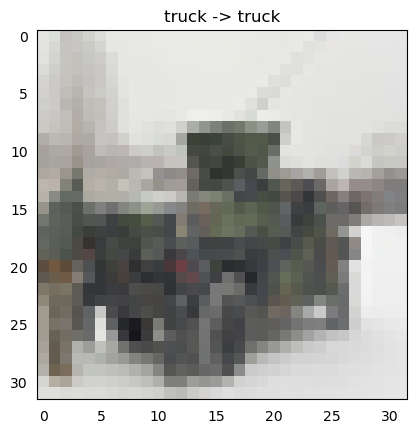

Key image: original prediction: truck edited prediction: truck
pre_edit_key_logits: [ 0.1792182   0.730646   -3.0005374   0.67254716 -2.2666497  -3.4071805
 -0.24158308  0.581082    0.32334018  6.4291816 ]
post_edit_key_logits: [ 0.53554916  0.14643274 -1.3171631   0.14101477 -0.63008136 -1.4259858
 -0.67846274 -1.3238815   2.1619644   2.3906503 ]


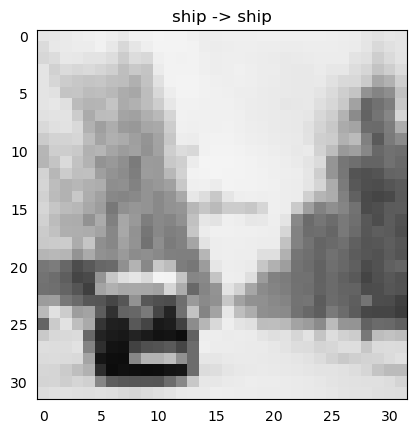

Value image: original prediction: ship edited prediction: ship


In [5]:
# Get features and logits of key, value, key neighbors and value neighbors before edit

# features
data_type = 'features'
pre_edit_features = pre_edit_knn[data_type]

pre_edit_key_features = pre_edit_features['anchor_data'][0]
pre_edit_key_neighbor_features = pre_edit_features['neighbor_data'][0]
pre_edit_key_neighbor_features_image_paths = pre_edit_features['image_paths'][0]
pre_edit_key_neighbor_features_labels = pre_edit_features['labels'][0]
pre_edit_key_neighbor_features_predictions = pre_edit_features['predictions'][0]

pre_edit_value_features = pre_edit_features['anchor_data'][1]
pre_edit_value_neighbor_features = pre_edit_features['neighbor_data'][1]
pre_edit_value_neighbor_features_image_paths = pre_edit_features['image_paths'][1]
pre_edit_value_neighbor_features_labels = pre_edit_features['labels'][1]
pre_edit_value_neighbor_features_predictions = pre_edit_features['predictions'][1]

# Repeat for after edit
post_edit_features = post_edit_knn[data_type]
post_edit_key_features = post_edit_features['anchor_data'][0]
post_edit_key_neighbor_features = post_edit_features['neighbor_data'][0]
post_edit_key_neighbor_features_image_paths = post_edit_features['image_paths'][0]
post_edit_key_neighbor_features_labels = post_edit_features['labels'][0]
post_edit_key_neighbor_features_predictions = post_edit_features['predictions'][0]

post_edit_value_features = post_edit_features['anchor_data'][1]
post_edit_value_neighbor_features = post_edit_features['neighbor_data'][1]
post_edit_value_neighbor_features_image_paths = post_edit_features['image_paths'][1]
post_edit_value_neighbor_features_labels = post_edit_features['labels'][1]
post_edit_value_neighbor_features_predictions = post_edit_features['predictions'][1]


# logits
data_type = 'logits'
pre_edit_logits = pre_edit_knn[data_type]
pre_edit_key_logits = pre_edit_logits['anchor_data'][0]
pre_edit_key_neighbor_logits = pre_edit_logits['neighbor_data'][0]
pre_edit_key_neighbor_logits_image_paths = pre_edit_logits['image_paths'][0]
pre_edit_key_neighbor_logits_labels = pre_edit_logits['labels'][0]
pre_edit_key_neighbor_logits_predictions = pre_edit_logits['predictions'][0]

pre_edit_value_logits = pre_edit_logits['anchor_data'][1]
pre_edit_value_neighbor_logits = pre_edit_logits['neighbor_data'][1]
pre_edit_value_neighbor_logits_image_paths = pre_edit_logits['image_paths'][1]
pre_edit_value_neighbor_logits_labels = pre_edit_logits['labels'][1]
pre_edit_value_neighbor_logits_predictions = pre_edit_logits['predictions'][1]

# Repeat for after edit
post_edit_logits = post_edit_knn[data_type]
post_edit_key_logits = post_edit_logits['anchor_data'][0]
post_edit_key_neighbor_logits = post_edit_logits['neighbor_data'][0]
post_edit_key_neighbor_logits_image_paths = post_edit_logits['image_paths'][0]
post_edit_key_neighbor_logits_labels = post_edit_logits['labels'][0]
post_edit_key_neighbor_logits_predictions = post_edit_logits['predictions'][0]

post_edit_value_logits = post_edit_logits['anchor_data'][1]
post_edit_value_neighbor_logits = post_edit_logits['neighbor_data'][1]
post_edit_value_neighbor_logits_image_paths = post_edit_logits['image_paths'][1]
post_edit_value_neighbor_logits_labels = post_edit_logits['labels'][1]
post_edit_value_neighbor_logits_predictions = post_edit_logits['predictions'][1]

pre_edit_key_prediction = class_list[np.argmax(pre_edit_key_logits)]
post_edit_key_prediction = class_list[np.argmax(post_edit_key_logits)]

# Images
data_type='images'
pre_edit_images = pre_edit_knn[data_type]
pre_edit_key_images = pre_edit_images['anchor_data'][0]
pre_edit_value_images = pre_edit_images['anchor_data'][1]

post_edit_images = post_edit_knn[data_type]
post_edit_key_images = post_edit_images['anchor_data'][0]
post_edit_value_images = post_edit_images['anchor_data'][1]

visualizations.show_image(
    pre_edit_key_images.reshape([3, 32, 32]),
    title="{} -> {}".format(pre_edit_key_prediction, post_edit_key_prediction),
    save_path=os.path.join(save_dir, "key_image.png"))

pre_edit_value_prediction = class_list[np.argmax(pre_edit_value_logits)]
post_edit_value_prediction = class_list[np.argmax(post_edit_value_logits)]
print("Key image: original prediction: {} edited prediction: {}".format(pre_edit_key_prediction, post_edit_key_prediction))
print("pre_edit_key_logits: {}".format(pre_edit_key_logits))
print("post_edit_key_logits: {}".format(post_edit_key_logits))
visualizations.show_image(
    pre_edit_value_images.reshape([3, 32, 32]),
    title="{} -> {}".format(pre_edit_value_prediction, post_edit_value_prediction),
    save_path=os.path.join(save_dir, "value_image.png"))
print("Value image: original prediction: {} edited prediction: {}".format(pre_edit_value_prediction, post_edit_value_prediction))

### Features Visualizations

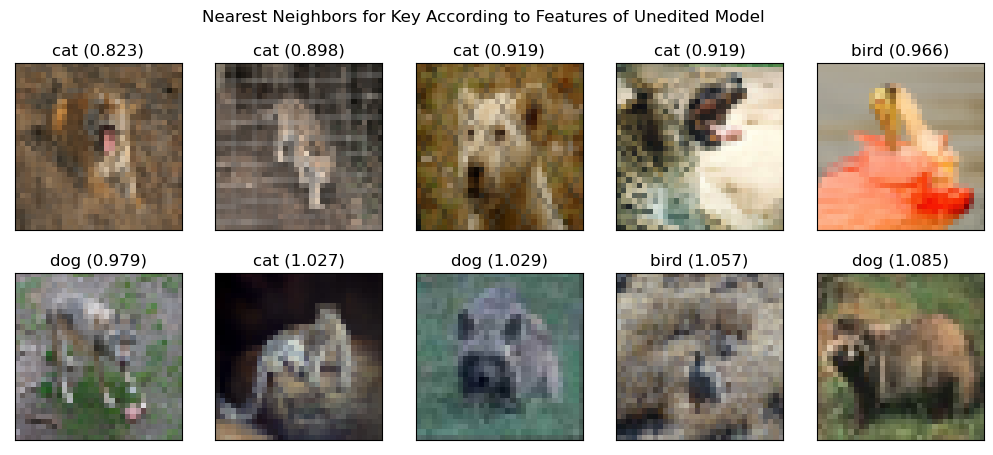

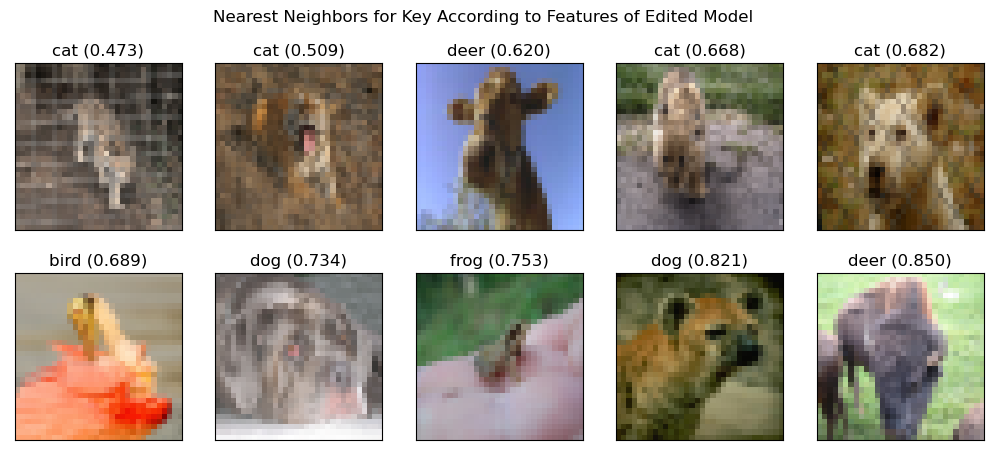

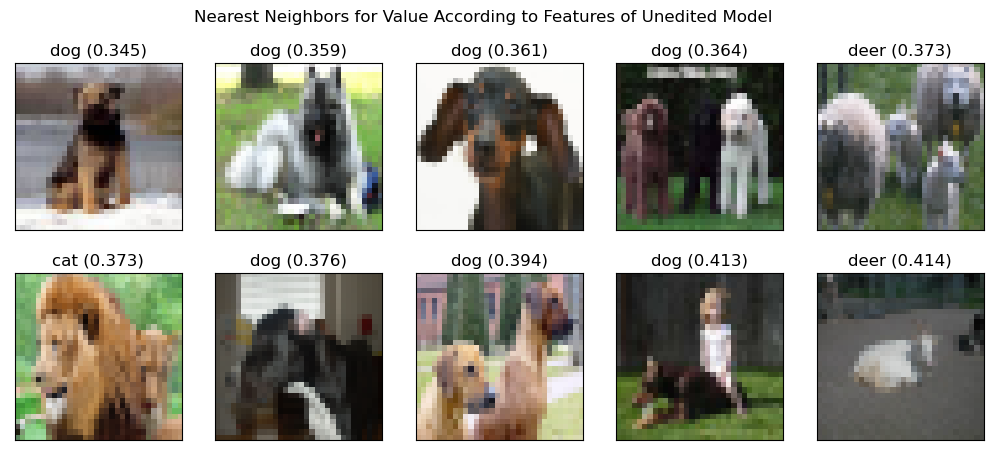

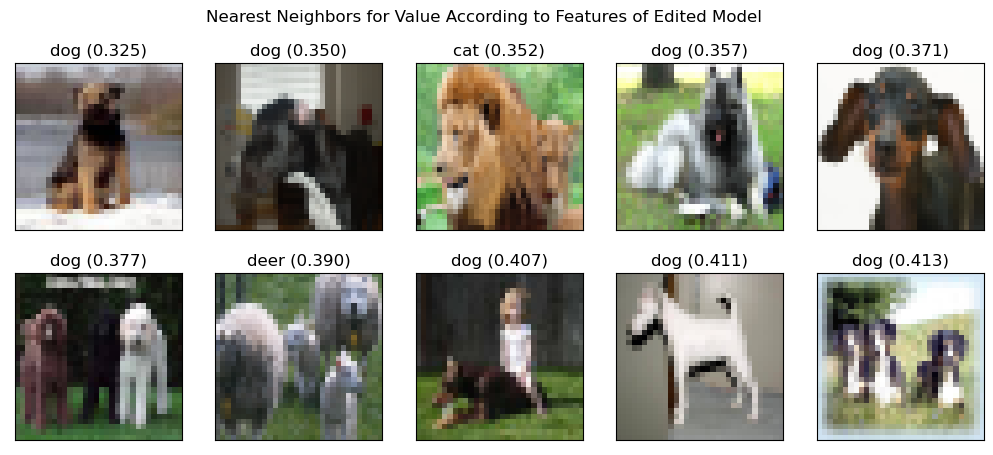

In [285]:
# Show visualizations for KNN for original and modified images according to unedited model

# Based on features first
# data_type = 'features'
# pre_edit_feature_knn = pre_edit_knn['features']
# post_edit_feature_knn = post_edit_knn['features']

# Pre edit features for key (tank2)
show_results(
    results=pre_edit_features, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_key_neighbors_features.png"))

# Post edit features for key (tank2)
show_results(
    results=post_edit_features, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_key_neighbors_features.png"))

# Features for value (tank1)
show_results(
    results=pre_edit_features, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_value_neighbors_features.png"))

show_results(
    results=post_edit_features, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_value_neighbors_features.png"))


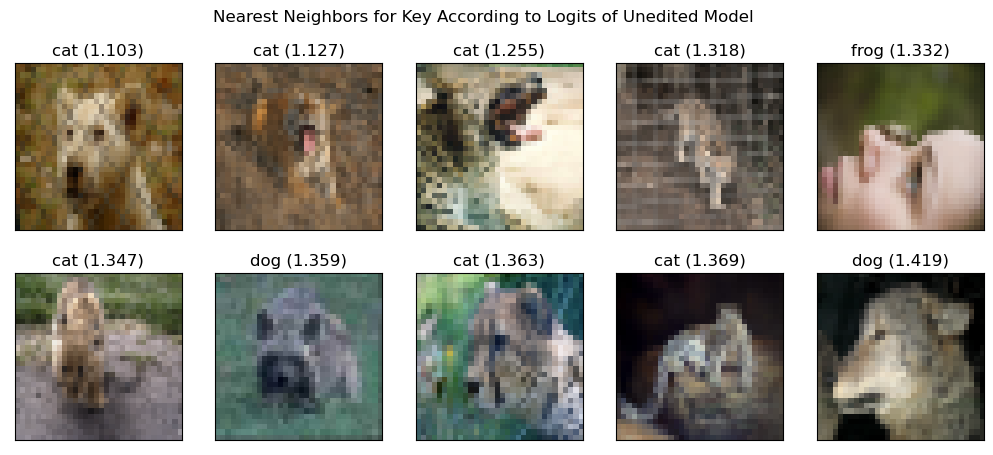

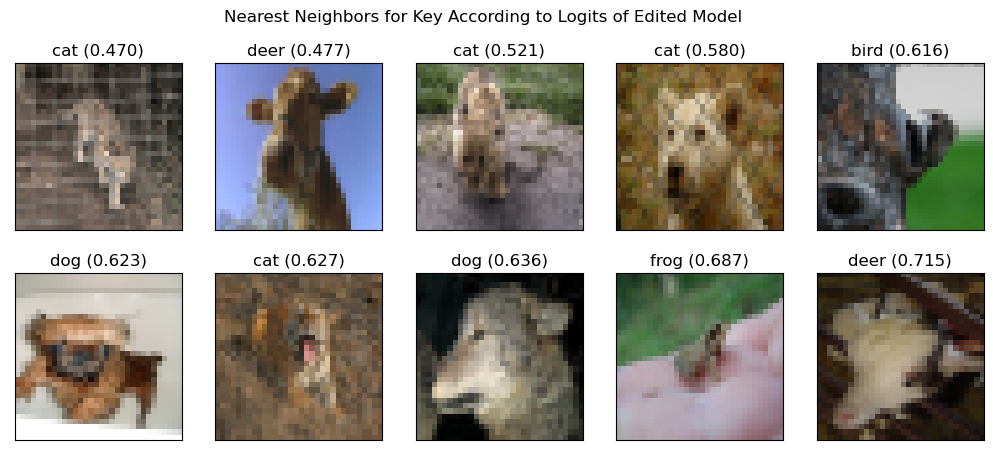

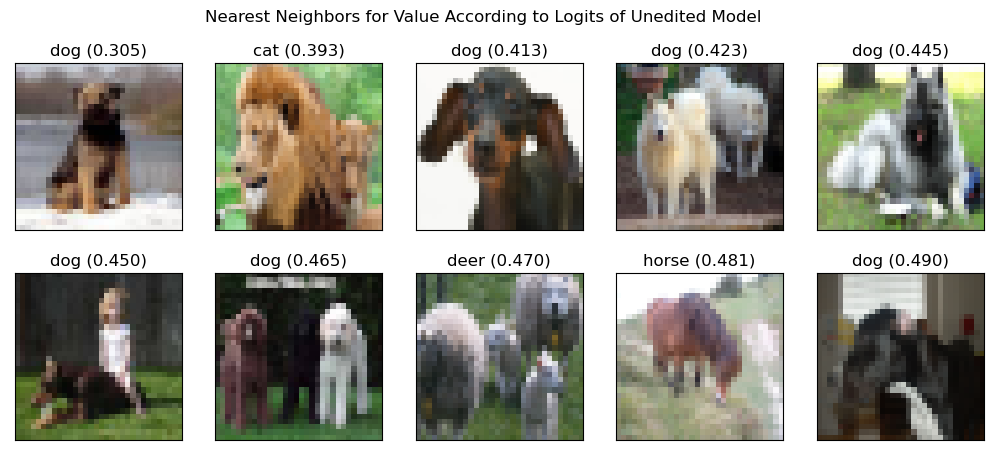

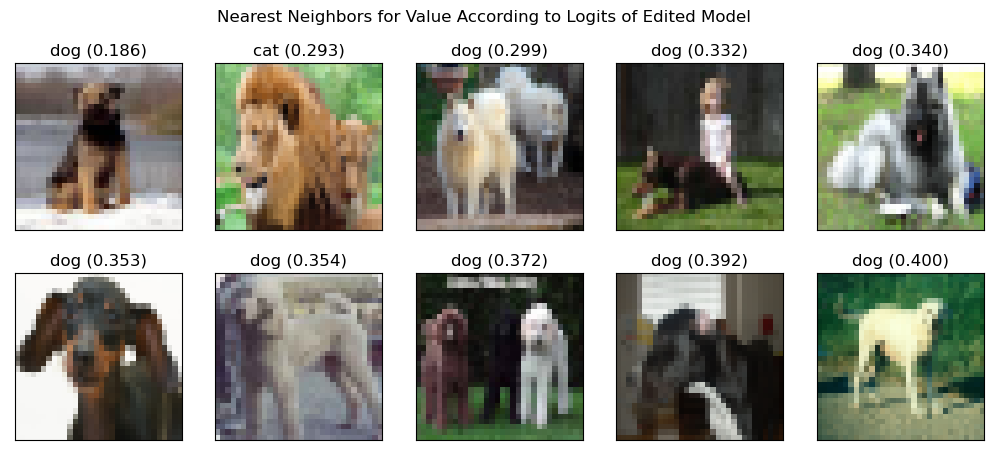

In [286]:
# LOGITS
# pre_edit_logits_knn = pre_edit_knn['logits']
# post_edit_logits_knn = post_edit_knn['logits']

# Logits for key (tank2)
show_results(
    results=pre_edit_logits, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_key_neighbors_logits.png"))
show_results(
    results=post_edit_logits, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_key_neighbors_logits.png"))

# Logits for value (tank1)
show_results(
    results=pre_edit_logits, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_value_neighbors_logits.png"))
show_results(
    results=post_edit_logits, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_value_neighbors_logits.png"))

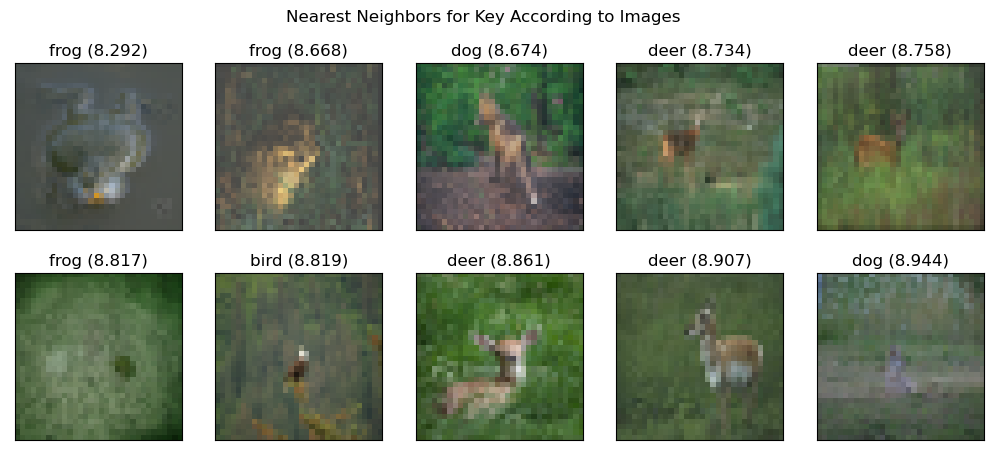

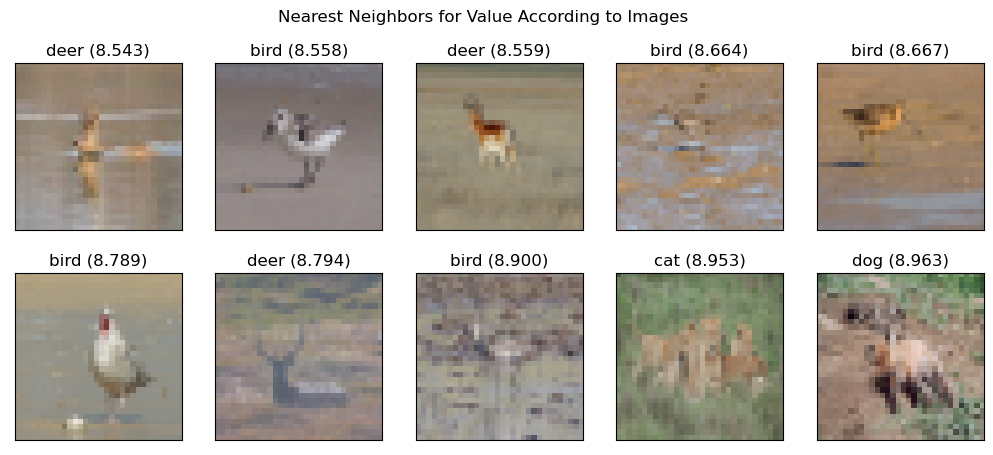

In [287]:
# IMAGES
pre_edit_images_knn = pre_edit_knn['images']
post_edit_images_knn = post_edit_knn['images']
# Features for key (tank2)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Images',
    save_path=os.path.join(save_dir, "key_neighbors_images.png"))

# Features for value (tank1)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Images',
    save_path=os.path.join(save_dir, "value_neighbors_images.png"))

### Understand how predictions of neighbors changed


In [6]:
def prediction_changes(image_paths,
                       class_list,
                       labels,
                       predictions=None,
                       model=None,
                       device=None):
    '''
    Examine labels and predictions of subset
    
    Arg(s):
        image_paths : list[str]
            list of paths to images
        class_list : list[str]
            C-length list with element being corresponding class name
        labels : N-length np.array
            ground truth labels of images at image_paths
        predictions : N-length np.array
            original predictions 
        model : 
            new model if want to calculate new predictions
    '''
    bar_chart_data = []
    group_names = []
    label_bins = np.bincount(labels)
    
    bar_chart_data.append(label_bins)
    group_names.append('Ground Truth')
    
    if predictions is not None:
        prediction_bins = np.bincount(predictions)
        
        bar_chart_data.append(prediction_bins)
        group_names.append('Orig. Pred.')
        
    print(label_bins, prediction_bins)
    if model is not None:
        assert device is not None
        
        logits = quick_predict(
            model=model,
            image_path=image_paths,
            device=device)
        
        model_predictions = torch.argmax(logits, dim=1)
        model_predictions = predictions.cpu().numpy()
        model_prediction_bins = np.bincount(model_predictions)
        
        bar_chart_data.append(model_prediction_bins)
        group_names.append('Model Pred.')
        
    

In [13]:
# Test above function

# for data_type in ['features', 'logits']:
#     for anchor_type in [0, 1]: # 0 : key, 1 : value
for data_type in ['features']:
    for anchor_type in [0]: # 0 : key, 1 : value
        image_paths = pre_edit_knn[data_type]['image_paths'][anchor_type]
        labels = pre_edit_knn[data_type]['labels'][anchor_type]
        predictions = pre_edit_knn[data_type]['predictions'][anchor_type]
        prediction_changes(
            image_paths=image_paths,
            labels=labels,
            class_list=class_list,
            predictions=predictions,
            model=edited_model,
            device=device)
        

[ 0  0  0  0  0  0  0  0  0 10] [ 0  0  0  0  0  0  0  0  0 10]


AttributeError: 'list' object has no attribute 'read'

### Given neighbors of the value image, find distances from key

In [288]:
from scipy.spatial import distance
def calculate_distance(u, v, metric='minkowski'):
    if metric == 'minkowski':
        return distance.minkowski(u, v)
    else:
        raise ValueError("Distance metric {} not supported.".format(metric))

In [290]:
# Sanity check that A's neighbors get the correct distances in feature space

features_results = pre_edit_knn['images']
knn_distances = features_results['distances'][0]
knn_image_paths = features_results['image_paths'][0]
flattened_key_image = np.copy(key_image)
flattened_key_image = flattened_key_image.flatten()

images = []
for path in knn_image_paths:
    
    image = load_image(path, resize=IMAGE_SIZE)
    image = image.flatten()
    images.append(image)

distances = calculate_distances(
    vectors=images,
    anchor=flattened_key_image
)
for knn_dist, minkowski_dist in zip(knn_distances, distances):
    assert np.abs(knn_dist - minkowski_dist) < 1e-5

In [291]:
# Distance between key and value before edit

pre_edit_key_val_feature_dist = calculate_distance(pre_edit_key_features, pre_edit_value_features)
post_edit_key_val_feature_dist = calculate_distance(post_edit_key_features, post_edit_value_features)
log("Distance between key and value in feature space before edit: {} after edit: {}".format(
    pre_edit_key_val_feature_dist, post_edit_key_val_feature_dist), log_path)

pre_edit_key_val_logit_dist = calculate_distance(pre_edit_key_logits, pre_edit_value_logits)
post_edit_key_val_logit_dist = calculate_distance(post_edit_key_logits, post_edit_value_logits)
log("Distance between key and value in logit space before edit: {} after edit: {}".format(
    pre_edit_key_val_logit_dist, post_edit_key_val_logit_dist), log_path)

Distance between key and value in feature space before edit: 4.935018062591553 after edit: 2.7549922466278076
Distance between key and value in logit space before edit: 7.426363945007324 after edit: 3.4072248935699463


### Key Image Neighbor Analysis

Find the top neighbors of the key image before the edit
Calculate the distances in the feature and logit space to the value image before and after the edit and see how they differ.

How to take into account the changes in the value image's representation in the feature and logit space due to the edit as well?

### Comparing Key Image with Value Neighbors FEATURES
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [292]:
log("Key image with value neighbors", log_path)
# Load images that are the pre-edit neighbors of value
# Only looking at features
pre_edit_value_neighbor_features_images = []
for path in pre_edit_value_neighbor_features_image_paths:
    pre_edit_value_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_features_images = torch.stack(pre_edit_value_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_features_images = pre_edit_value_neighbor_features_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_features_images)
    pre_edit_value_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.reshape(
        [pre_edit_value_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_key_to_pre_value_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_features,
    anchor=pre_edit_key_features)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_key_to_pre_value_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_features,
    anchor=post_edit_key_features)

log("Features", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
log(str(pre_key_to_pre_value_neighbors_features_distances), log_path)
log("Average distance: {}".format(np.mean(pre_key_to_pre_value_neighbors_features_distances)), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
log(str(post_key_to_pre_value_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(np.mean(post_key_to_pre_value_neighbors_edited_features_distances)), log_path)

log("", log_path)


Key image with value neighbors
Features
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[4.97967863 5.07582569 4.99217176 5.01577854 5.07990932 4.89940596
 4.91656733 4.80496216 5.03705549 4.82734728 4.90587521 5.12221241
 4.87095928 4.86110878 4.92707062 4.81731462 5.04504347 5.0436244
 5.16460037 4.94140339 4.9257555  4.9302597  4.90634823 5.00996113
 5.13207102 5.10921669 4.77019405 4.88304234 4.82625055 4.88718939
 5.06084347 4.81222582 5.12817383 4.88333416 4.81529999 5.16261196
 5.13354969 4.91509962 5.06280088 5.05674744 5.00799179 4.60213804
 5.16042423 5.13241291 5.06225252 4.78478575 4.88331842 5.05315304
 5.04268742 4.95378447 5.17650938 5.15536404 4.98321533 4.94679785
 5.1488204  5.14207125 4.75081968 5.05014992 4.79531956 5.03018856
 5.18061686 4.84159565 4.80352736 4.79049349 5.24341106 4.92329311
 4.83758259 4.64380074 4.85335445 5.10674143 5.08107042 4.81139135
 4.81644344 5.11965084 5.19277668 5.14038181 4.91458607 5.13119268
 4.7802

### Comparing Key Image with Value Neighbors LOGITS
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [293]:
# Load images that are the pre-edit neighbors of value
# Only looking at logits
pre_edit_value_neighbor_logits_images = []
for path in pre_edit_value_neighbor_logits_image_paths:
    pre_edit_value_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_logits_images = torch.stack(pre_edit_value_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_logits_images = pre_edit_value_neighbor_logits_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_logits_images)

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()

# Calculate distances between key and neighbors of value before the edit
pre_key_to_pre_value_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_logits,
    anchor=pre_edit_key_logits)

pre_key_to_pre_value_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_logits,
    anchor=post_edit_key_logits)

log("Logits", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
log(str(pre_key_to_pre_value_neighbors_logits_distances), log_path, log_path)
log("Average distance: {}".format(np.mean(pre_key_to_pre_value_neighbors_logits_distances)), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
log(str(pre_key_to_pre_value_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(np.mean(pre_key_to_pre_value_neighbors_edited_logits_distances)), log_path)

log("", log_path)
log("---***---", log_path)

Logits
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[7.46807384 7.3472662  7.53561687 7.5871892  7.64741755 7.59926224
 7.56050777 7.64643574 7.44972754 7.40108824 7.59882689 7.41206694
 7.80080271 7.23839045 7.70663023 7.70839834 7.44343853 7.54289055
 7.23959637 7.35930872 7.27838421 7.77873564 7.70214558 7.08724499
 7.76067305 7.61678743 7.59249401 7.82365942 7.33046055 7.23147249
 7.911623   7.39833021 7.32119942 7.79270172 7.65788651 7.4590416
 7.21115541 7.68100834 7.40667391 7.30950928 7.77169228 7.34622145
 7.5313549  7.72895384 7.21297693 7.3582139  7.70771027 7.15439272
 7.70820999 7.70164537 7.53320408 7.8298068  7.63993979 7.68025827
 7.29128027 6.90645552 7.0962286  7.15074348 7.83390665 7.61370897
 7.40383673 7.19071293 7.77011347 7.31644869 7.37392998 7.65113449
 7.90353966 7.52389908 7.7699542  7.16083908 6.94284678 7.60894346
 7.22681236 7.39145422 7.17178011 7.83266354 7.90601444 7.72187376
 7.19027567 7.77059984 7.67792082 7.0276

### Comparing Value Image with Key Neighbors FEATURES
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [294]:
# Load images that are the pre-edit neighbors of key
# Only looking at features
log("Value Image with Key Neighbors", log_path)
pre_edit_key_neighbor_features_images = []
for path in pre_edit_key_neighbor_features_image_paths:
    pre_edit_key_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_features_images = torch.stack(pre_edit_key_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_features_images = pre_edit_key_neighbor_features_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_features_images)
    pre_edit_key_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.reshape(
        [pre_edit_key_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_features,
    anchor=pre_edit_value_features)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_features,
    anchor=post_edit_value_features)

log("Features", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
log(str(pre_value_to_pre_key_neighbors_features_distances), log_path)
log("Average distance: {}".format(np.mean(pre_value_to_pre_key_neighbors_features_distances)), log_path)
log("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
log(str(post_value_to_pre_key_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(np.mean(post_value_to_pre_key_neighbors_edited_features_distances)), log_path)

log("", log_path)

Value Image with Key Neighbors
Features
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[4.56621981 4.17301464 4.52479696 5.244555   5.54113245 5.32795954
 5.4083457  5.15788174 5.3273797  5.38146687 4.85386086 5.14043856
 4.29946327 5.24775696 4.76073122 5.3695569  5.76397324 5.65041161
 5.7081337  5.83339834 5.27815294 4.66082573 5.4376502  4.87465
 4.75147629 4.53833389 5.54213428 4.64855051 4.36051941 4.40293217
 5.13801908 5.12421227 5.10441113 5.70223856 5.71459436 5.98166895
 5.72675705 5.26410389 5.22171164 5.94788122 4.55312681 5.3869276
 5.45673847 4.13810539 5.54969835 4.8305974  6.02623892 5.34089184
 5.77799416 4.63633299 5.68477583 6.09517479 4.81302929 5.12929964
 5.71022129 6.03688812 5.66285944 5.79612827 5.9799757  6.13239384
 4.2607584  5.99879837 4.28596401 4.80455351 5.84854174 5.91219139
 5.44291878 5.7731204  5.47164011 4.6847887  6.07632685 3.97229123
 4.1581502  4.60817146 5.05203962 5.17457533 5.96240091 5.9500308
 5.90895891

### Comparing Value Image with Key Neighbors LOGITS
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [295]:
# Load images that are the pre-edit neighbors of key
# Only looking at logits
pre_edit_key_neighbor_logits_images = []
for path in pre_edit_key_neighbor_logits_image_paths:
    pre_edit_key_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_logits_images = torch.stack(pre_edit_key_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_logits_images = pre_edit_key_neighbor_logits_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_logits_images)

# Move  logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_logits = pre_edit_key_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_logits,
    anchor=pre_edit_value_logits)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_logits,
    anchor=post_edit_value_logits)

log("logits", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
log(str(pre_value_to_pre_key_neighbors_logits_distances), log_path)
log("Average distance: {}".format(np.mean(pre_value_to_pre_key_neighbors_logits_distances)), log_path)

log("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
log(str(post_value_to_pre_key_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(np.mean(post_value_to_pre_key_neighbors_edited_logits_distances)), log_path)


logits
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[6.87818575 7.03919649 8.04516029 6.20880747 7.16363049 6.48765135
 7.64388371 7.93342304 8.02935982 7.632658   8.19996548 7.37231159
 7.82146692 6.99898005 7.04285145 8.15677357 8.44337368 7.31742001
 8.24540138 8.01408005 8.26939869 8.07115555 7.40008211 7.98449898
 8.48105717 6.30978012 6.70503569 7.11597919 8.72699547 8.20833969
 6.6100316  8.66759205 8.83055115 6.91208744 7.47074175 7.27268457
 7.62908602 6.78101158 7.90667248 6.89640522 8.52558041 8.32024574
 7.17680693 8.30780029 7.7460885  8.73438263 6.55431366 8.60169983
 6.39352608 8.92984962 8.12151241 6.29245853 7.29506683 7.17893887
 8.89667034 8.58708096 8.60439396 8.6009655  7.80715132 6.87285328
 9.13707829 8.99940872 8.73274708 7.76823616 5.92365789 8.88919067
 8.98329544 9.19944572 8.81992626 7.89352846 7.76759577 7.90937138
 8.81399059 8.27113628 8.06548691 7.52744818 8.54756641 8.38027477
 7.15446568 5.94834709 7.71017599 8.950

### Comparing Key Image with Key Neighbors FEATURES
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model


In [296]:
log("Key image with key neighbors", log_path)
# Load images that are the pre-edit neighbors of key
# Only looking at features
pre_edit_key_neighbor_features_images = []
for path in pre_edit_key_neighbor_features_image_paths:
    pre_edit_key_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_features_images = torch.stack(pre_edit_key_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_features_images = pre_edit_key_neighbor_features_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_model(pre_edit_key_neighbor_features_images)
    pre_edit_key_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.reshape(
        [pre_edit_key_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
# pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of key before the edit 
pre_key_to_pre_key_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_features,
    anchor=pre_edit_key_features)

# Calculate feature distances between key post edit and key's original neighbors via post edit model
post_key_to_pre_key_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_features,
    anchor=post_edit_key_features)

log("Features", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
log(str(pre_key_to_pre_key_neighbors_features_distances), log_path)
log("Average distance: {}".format(np.mean(pre_key_to_pre_key_neighbors_features_distances)), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
log(str(post_key_to_pre_key_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(np.mean(post_key_to_pre_key_neighbors_edited_features_distances)), log_path)

log("", log_path)


Key image with key neighbors
Features
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[0.82262051 0.89829779 0.91872215 0.91889048 0.96637422 0.97870821
 1.02717257 1.02891731 1.05748093 1.08492243 1.11354625 1.11630082
 1.11788452 1.13944113 1.14614034 1.14960253 1.15338802 1.1604681
 1.16501307 1.17002308 1.17878556 1.18622112 1.18953824 1.19169402
 1.20373237 1.2122705  1.21416044 1.21796334 1.23395896 1.26886964
 1.27633429 1.28079426 1.28476799 1.28549981 1.2881335  1.29591632
 1.30941999 1.32521355 1.33008397 1.33527672 1.33592284 1.33814311
 1.34086084 1.34163511 1.35464144 1.3644259  1.36624527 1.37849092
 1.38039863 1.38307464 1.38382769 1.39126801 1.39302886 1.40564442
 1.41144979 1.42949486 1.43896949 1.44248748 1.44908893 1.45029044
 1.45645607 1.45923817 1.46151674 1.46616662 1.4720155  1.47459209
 1.47788322 1.47823489 1.48539388 1.48589599 1.48792517 1.49094617
 1.5001111  1.50354624 1.50779843 1.51046002 1.51796579 1.52254462
 1.52618706

### Comparing Key Image with Key Neighbors LOGITS
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [297]:
log("Key image with key neighbors", log_path)
# Load images that are the pre-edit neighbors of key
# Only looking at logits
pre_edit_key_neighbor_logits_images = []
for path in pre_edit_key_neighbor_logits_image_paths:
    pre_edit_key_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_logits_images = torch.stack(pre_edit_key_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_logits_images = pre_edit_key_neighbor_logits_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_model(pre_edit_key_neighbor_logits_images)

# Move logits and logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_logits = pre_edit_key_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between key and neighbors of key before the edit 
pre_key_to_pre_key_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_logits,
    anchor=pre_edit_key_logits)

# Calculate feature distances between key post edit and key's original neighbors via post edit model
post_key_to_pre_key_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_logits,
    anchor=post_edit_key_logits)

log("Logits", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
log(str(pre_key_to_pre_key_neighbors_logits_distances), log_path)
log("Average distance: {}".format(np.mean(pre_key_to_pre_key_neighbors_logits_distances)), log_path)

log("Anchor: key || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
log(str(post_key_to_pre_key_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(np.mean(post_key_to_pre_key_neighbors_edited_logits_distances)), log_path)

log("", log_path)


Key image with key neighbors
Logits
Anchor: key || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[1.10346067 1.12656212 1.25524926 1.31844854 1.33235538 1.346995
 1.35924864 1.36324859 1.36866379 1.41911972 1.41933191 1.42480779
 1.4253763  1.44317281 1.46932602 1.47797668 1.492769   1.51061285
 1.52098811 1.534464   1.55122662 1.5646385  1.58105564 1.60944247
 1.62419486 1.63036716 1.63370633 1.65331841 1.66092885 1.66697752
 1.67679703 1.68380189 1.69033742 1.72934675 1.72949004 1.73220038
 1.75013018 1.76415825 1.78039968 1.79579127 1.79796457 1.80001569
 1.80689943 1.82555151 1.84938443 1.85024917 1.86200249 1.87440765
 1.90534461 1.91314864 1.93709147 1.95301998 1.95709443 1.97992349
 1.9847033  1.98864269 2.00037432 2.00588536 2.00701571 2.0116117
 2.02520657 2.02742434 2.03240538 2.03262949 2.03681231 2.0412066
 2.04332757 2.04791832 2.0497818  2.05003667 2.0513494  2.05473185
 2.05567503 2.06611037 2.0749743  2.07531905 2.084445   2.08862329
 2.0988884  2.11

### Comparing Value Image with Value Neighbors FEATURES
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model

In [298]:
log("Value image with value neighbors", log_path)
# Load images that are the pre-edit neighbors of value
# Only looking at features
pre_edit_value_neighbor_features_images = []
for path in pre_edit_value_neighbor_features_image_paths:
    pre_edit_value_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_features_images = torch.stack(pre_edit_value_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for value image
    pre_edit_value_neighbor_features_images = pre_edit_value_neighbor_features_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_features_images)
    pre_edit_value_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.reshape(
        [pre_edit_value_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
# pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between value and neighbors of value before the edit 
pre_value_to_pre_value_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_features,
    anchor=pre_edit_value_features)

# Calculate feature distances between value post edit and value's original neighbors via post edit model
post_value_to_pre_value_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_features,
    anchor=post_edit_value_features)

log("Features", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
log(str(pre_value_to_pre_value_neighbors_features_distances), log_path)
log("Average distance: {}".format(np.mean(pre_value_to_pre_value_neighbors_features_distances)), log_path)

log("Anchor: value || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
log(str(post_value_to_pre_value_neighbors_edited_features_distances), log_path)
log("Average distance: {}".format(np.mean(post_value_to_pre_value_neighbors_edited_features_distances)), log_path)

log("", log_path)

Value image with value neighbors
Features
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[0.34510502 0.35897389 0.36120498 0.36425686 0.37307405 0.37310687
 0.37569004 0.39350656 0.41270262 0.41411829 0.42175025 0.42539406
 0.43614754 0.43863156 0.44294423 0.44381979 0.44537607 0.44905624
 0.45067218 0.45143342 0.45374545 0.45751825 0.45817479 0.46044171
 0.46832624 0.47077891 0.47818795 0.48500544 0.4931584  0.50798434
 0.51070672 0.51183838 0.51450217 0.5146122  0.51628733 0.51911509
 0.51946038 0.52377361 0.52603996 0.54009026 0.55322355 0.56444186
 0.56451422 0.56827253 0.56922132 0.57112002 0.57124627 0.57260573
 0.57316649 0.57725334 0.58097225 0.58181131 0.58261037 0.59316462
 0.59411609 0.59759724 0.59834337 0.59859818 0.59948772 0.6025216
 0.60255104 0.60400605 0.60499507 0.60839361 0.61024189 0.61400259
 0.61820775 0.62101203 0.62231773 0.62806028 0.63043368 0.63684869
 0.63764691 0.639745   0.64242667 0.64331394 0.64408076 0.64488441
 0.

### Comparing Value Image with Value Neighbors LOGITS
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model

In [299]:
log("Value image with value neighbors", log_path)
# Load images that are the pre-edit neighbors of value
# Only looking at logits
pre_edit_value_neighbor_logits_images = []
for path in pre_edit_value_neighbor_logits_image_paths:
    pre_edit_value_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_logits_images = torch.stack(pre_edit_value_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for value image
    pre_edit_value_neighbor_logits_images = pre_edit_value_neighbor_logits_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_logits_images)

# Move logits and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between value and neighbors of value before the edit 
pre_value_to_pre_value_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_logits,
    anchor=pre_edit_value_logits)

# Calculate feature distances between value post edit and value's original neighbors via post edit model
post_value_to_pre_value_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_logits,
    anchor=post_edit_value_logits)

log("Logits", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
log(str(pre_value_to_pre_value_neighbors_logits_distances), log_path)
log("Average distance: {}".format(np.mean(pre_value_to_pre_value_neighbors_logits_distances)), log_path)

log("Anchor: value || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
log(str(post_value_to_pre_value_neighbors_edited_logits_distances), log_path)
log("Average distance: {}".format(np.mean(post_value_to_pre_value_neighbors_edited_logits_distances)), log_path)

log("", log_path)


Value image with value neighbors
Logits
Anchor: value || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[0.30543837 0.3933903  0.41253781 0.42333055 0.44531015 0.4498105
 0.46515742 0.47027546 0.480753   0.48978406 0.49077937 0.49552983
 0.51477391 0.52201724 0.53129458 0.54238194 0.56509864 0.58282399
 0.59655291 0.60094404 0.60174668 0.60438758 0.61150938 0.61993885
 0.62508208 0.63236815 0.63430452 0.64994222 0.65282422 0.66113931
 0.66157746 0.66173059 0.66213751 0.66594321 0.66820848 0.67309391
 0.68109655 0.69362652 0.69376642 0.69424647 0.69512314 0.69777536
 0.69910234 0.70147496 0.70318508 0.70396829 0.70576191 0.70895386
 0.71018404 0.71270591 0.7162196  0.71755683 0.72650522 0.73241055
 0.73275262 0.73979545 0.7436651  0.74576235 0.75535977 0.75883162
 0.76138037 0.76308662 0.76418293 0.7700507  0.77140498 0.77171904
 0.77326101 0.79070455 0.79321098 0.79675704 0.8040309  0.81918079
 0.82162827 0.82299113 0.82806569 0.83019567 0.83710766 0.83801395
 0.84